# Challenges and Questions: final project phase
___

In [1]:
import sys
import os

milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess
from bert_models import BERTModel

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initially, we'll identify which model performs best for our task (assumption: `HateBERT`). To do this, we'll start with the base scenario: a balanced or unbalanced dataset with the initial labels. 

Once we determine the best model, we'll retrain it using various scenarios, including both balanced and unbalanced datasets, along with 3 distinct types of label aggregation: `original` (provided by the dataset creators), `majority voting` (applied to the labels from 3 annotators) and `at least one sexist` (where a label is "sexist" if at least 1 annotator assigned it as such). These combinations of dataset type and aggregation method yield 6 distinct configurations for model training.

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_train_balanced, y_train_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

# different aggregation methods
y_train_mv, y_train_balanced_mv, y_val_mv, y_test_mv = import_preprocess.apply_aggregation(aggregation_type='majority voting')
y_train_alos, y_train_balanced_alos, y_val_alos, y_test_alos = import_preprocess.apply_aggregation(aggregation_type='at least one sexist')

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_train_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


# BERT-based models

We're exploring pre-trained models available on the Hugging Face model repository. We're using their pre-trained weights, coupled with tokenizers as our starting point. We're fine-tuning them to adapt them to our downstream task. We've implemented 2 approaches for fine-tuning (each requiring slightly different preprocessing steps).

#### 2 different types of fine-tuning

1. PyTorch fine-tuning

(`prepare_X` and `prepare_dataset` methods for pre-processing and `train` for training)
We've implemented the training loop using Pytorch. The process is straightforward: epoch-by-epoch and batch-by-batch, performing a forward pass through the network, computing the loss, backpropagating errors and updating parameters using gradient descent.

In [3]:
# model = BERTModel("HateBERT")
# model.train(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3, plot_training_curve=True)

2. Hugging Face Trainer API -> extremely slow :(

(`prepare_dataset_hf` method for pre-processing and `train_hugging_face_api` for training) HF provides Trainer API, which simplifies the training process by eliminating the need for manually implementing the training loop and various convinient features (such as early stopping, regularization, logging etc). Although this approach provides flexibility, in our case it resulted in way longer training times and higher overhead. Therefore, we decided to proceed with the first approach - PyTorch fine-tuning.

In [4]:
# model = BERTModel("HateBERT")
# model.train_hugging_face_api(X_train[:30], y_train[:30], X_val[:10], y_val[:10], epochs=10, patience=3)

### Training and evaluating various BERT-based models

In [5]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### **1. RoBERTa**

https://arxiv.org/abs/1907.11692 (paper)

Key features of the original RoBERTa:
- improvement over BERT
- pre-trained in a self-supervised manner: raw texts only, with no humans labelling 
- dynamic masking: 
    - BERT uses static masking during pretraining (the same tokens are masked across all training epochs)
    - RoBERTa uses dynamic masking, where tokens are randomly masked in each epoch
- next sentence prediction loss (NSP):
    - BERT: includes NSP as part of its pretraining objective, where the model learns to predict whether one sentence logically follows another
    - RoBERTa: removes NSP because experiments showed that removing it leads to better results
- pre-training objective:
    - BERT: masked language modeling (MLM) objective along with the NSP task
    - RoBERTa: only the MLM objective 
- larger training data and batch size:
    - BERT: pretrained on 16GB of data (BooksCorpus and English Wikipedia); small batch size; 1 million training steps (pass of a batch)
    - RoBERTa: 10 times more data; larger batch size; 500,000 training steps

HF model we're using: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
- trained on ~124M tweets from January 2018 to December 2021 and finetuned for sentiment analysis with the TweetEval benchmark
- labels of the pre-trained model: 0 - negative; 1 - neutral; 2 - positive; by setting `ignore_mismatched_sizes=True` while loading the pre-trained model, the weights of the output layer won't be loaded, instead, they will be randomly initialized


Loading pretrained weights: RoBERTa...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model RoBERTa: 124647170


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Training started.
Epoch 1/10, Cross-entropy Loss: 178.8231
Validation Loss: 21.4556, Validation Accuracy: 0.8615
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 137.7345
Validation Loss: 20.7674, Validation Accuracy: 0.8670
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 100.1385
Validation Loss: 24.8332, Validation Accuracy: 0.8520
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 62.5162
Validation Loss: 25.1165, Validation Accuracy: 0.8495
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 40.9223
Validation Loss: 31.6951, Validation Accuracy: 0.8495
No improvement. Patience: 3/3
Early stopping triggered.


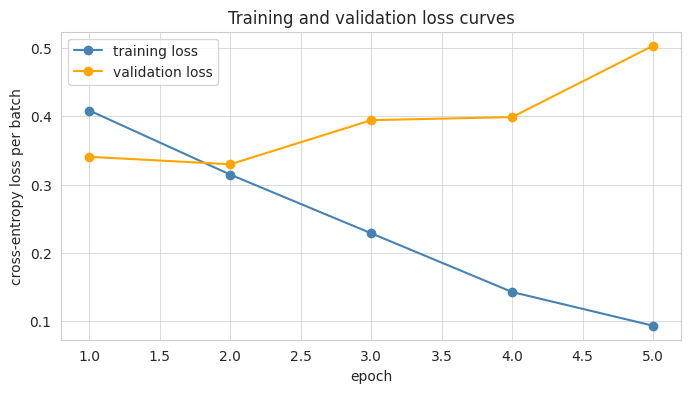

########################################

Metrics for training
accuracy: 0.9916
balanced accuracy: 0.9912
precision: 0.9756
recall: 0.9903

########################################

Metrics for validation
accuracy: 0.8495
balanced accuracy: 0.8014
precision: 0.6839
recall: 0.7078

########################################



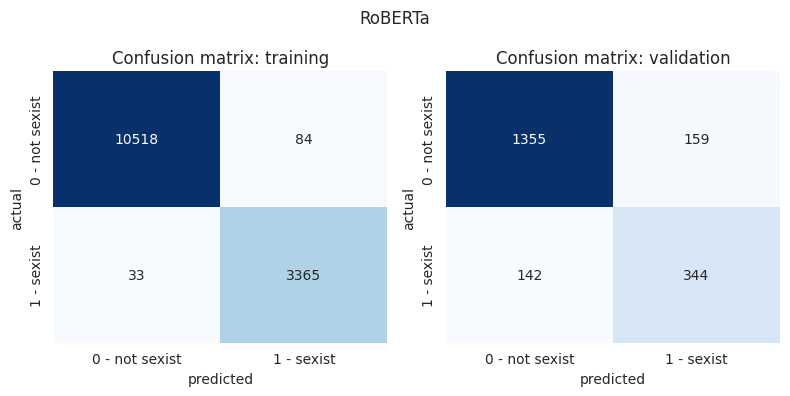

In [6]:
roberta_model = BERTModel("RoBERTa")
roberta_model.count_parameters()
roberta_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = roberta_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=roberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

roberta_model.clear_gpu_memory()

#### **2. DeBERTa**

https://arxiv.org/abs/2006.03654 (paper)

Key features of the original DeBERTa:
- improvement over BERT and RoBERTa
- handling content and position information:
    - BERT: adds positional encoding to the embedding vectors to incorporate position information
    - DeBERTa: uses disentangled attention mechanism - each word represented with 2 separate vectors (1 encoding content and the other encoding position); attention weights are computed using disentangled matrices that separately handle content and positional information
- decoder part: 
    - BERT: uses the standard transformer encoder and positional encodings during the input processing, without a separate decoder mechanism
    - DeBERTa: uses enhanced mask decoder - the decoding layer incorporates absolute positions, allowing the model to better capture positional relationships and improve its ability to predict masked tokens.
- virtual adversarial training (VAT) method is used during fine-tuning to enhance generalization (making the model less sensitive to slight input changes and improving performance on downstream tasks)
- training data:
    - RoBERTa: ~160GB data
    - DeBERTa: trained on half of the training data used for RoBERTa-Large, but outperforms it across multiple NLP tasks

HF model we're using: https://huggingface.co/microsoft/deberta-v3-base

- base DeBERTa model fine-tuned with MNLI task (multi-genre natural language inference): determine the relationship between 2 sentences (3 categories: 1. entailment: 2nd sentence logically follows from the 1st, 2. contradiction: 2nd contradicts the 1st, 3. neutral)
- it might be better if we manage to find some model that was fine-tuned on the social media data or fine-tuned on some task more similar to our

Loading pretrained weights: DeBERTa...


You are using a model of type deberta-v2 to instantiate a model of type deberta. This is not supported for all configurations of models and can yield errors.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'deberta.encoder.layer.0.attention.self.in_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_proj.weight', 'deberta.encoder.layer.0.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.0.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.0.attention.self.q_bias', 'deberta.encoder.layer.0.attention.self.v_bias', 'deberta.encoder.layer.1.attention.self.in_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_proj.weight', 'deberta.encoder.layer.1.attention.self.pos_q_proj.bias', 'deberta.encoder.layer.1.attention.self.pos_q_proj.weight', 'deberta.encoder.layer.1.attention.self.q_bias', 'deberta.encoder.layer.1.attention.s

Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model DeBERTa: 198971138
Training started.
Epoch 1/10, Cross-entropy Loss: 244.1841
Validation Loss: 35.1972, Validation Accuracy: 0.7570
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 243.4695
Validation Loss: 35.0697, Validation Accuracy: 0.7570
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 243.5128
Validation Loss: 34.8345, Validation Accuracy: 0.7570
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 4/10, Cross-entropy Loss: 243.5673
Validation Loss: 34.9503, Validation Accuracy: 0.7570
No improvement. Patience: 1/3
Epoch 5/10, Cross-entropy Loss: 243.5687
Validation Loss: 34.8319, Validation Accuracy: 0.7570
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 6/10, Cross-entropy Loss: 243.5533
Va

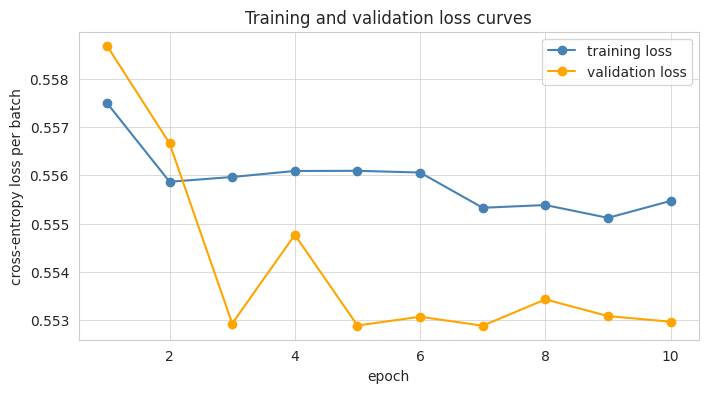

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



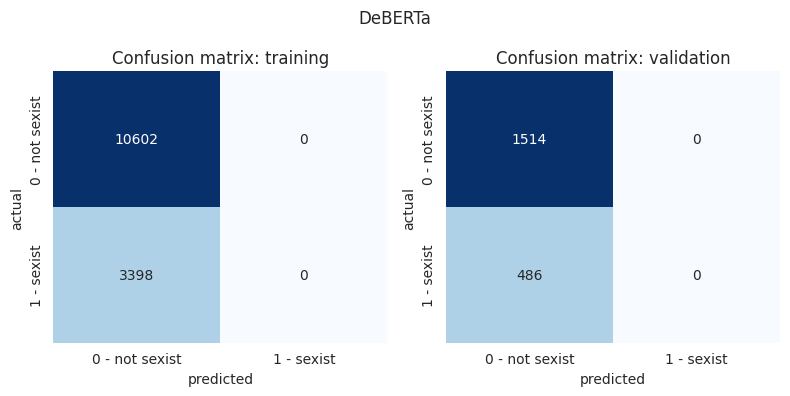

In [7]:
deberta_model = BERTModel("DeBERTa")
deberta_model.count_parameters()
deberta_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = deberta_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=deberta_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

deberta_model.clear_gpu_memory()

#### **3. HateBERT**

https://arxiv.org/abs/2010.12472 (paper)

- inherits BERT's transformer-based architecture, fine-tuned on a large dataset of hateful and abusive language from online forums
- re-trained on the RAL-E dataset, a large-scale dataset of Reddit comments in English from communities banned for being offensive, abusive or hateful
- HateBERT outperforms general-purpose language models (e.g., BERT, RoBERTa) in tasks related to hate speech detection because it was fine-tuned on domain-specific data
- it excels at recognizing toxic language, but its specificity to certain datasets (like Reddit) may limit its generalizability to other platforms or contexts
- may inherit biases from the training data, potentially leading to false positives or negatives

HF model we're using: https://huggingface.co/GroNLP/hateBERT
- further trained on over 1 million posts from banned Reddit communities (abusive, offensive or hateful content)
- builds upon the BERT base uncased model, adapting it for downstream task

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 161.5776
Validation Loss: 20.3318, Validation Accuracy: 0.8655
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 101.9863
Validation Loss: 21.5444, Validation Accuracy: 0.8585
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 44.6416
Validation Loss: 28.2315, Validation Accuracy: 0.8585
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 23.0674
Validation Loss: 32.0216, Validation Accuracy: 0.8625
No improvement. Patience: 3/3
Early stopping triggered.


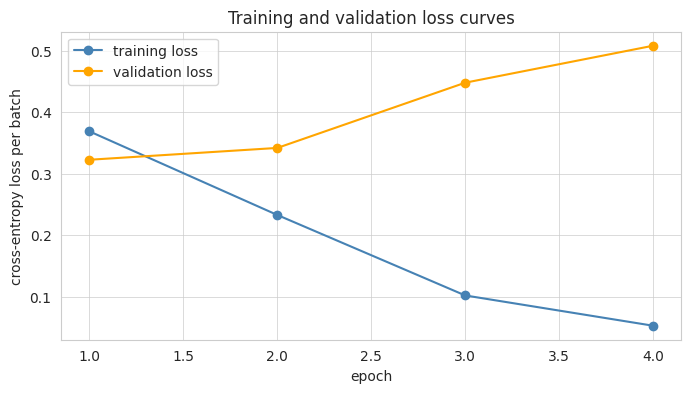

########################################

Metrics for training
accuracy: 0.9964
balanced accuracy: 0.9954
precision: 0.9915
recall: 0.9935

########################################

Metrics for validation
accuracy: 0.8625
balanced accuracy: 0.7862
precision: 0.7579
recall: 0.6379

########################################



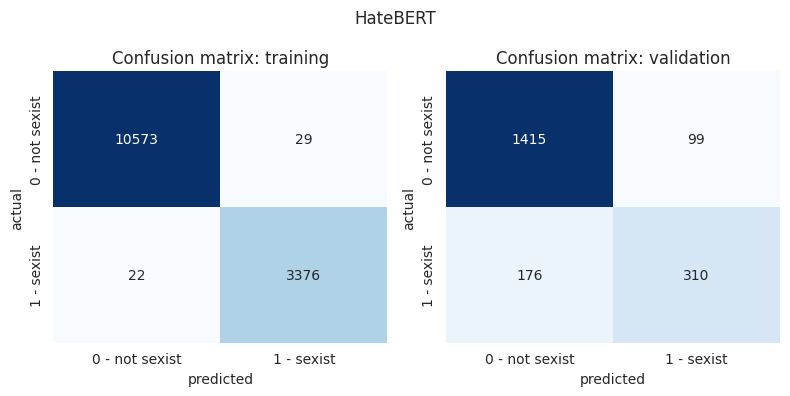

In [8]:
hatebert_model = BERTModel("HateBERT")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

hatebert_model.clear_gpu_memory()

#### **4. DistilBERT**

https://arxiv.org/abs/1910.01108 (paper)

- smaller, faster and more efficient version of the BERT model
- the model is 40% smaller than the original BERT, reducing computational and storage requirements significantly
- despite being smaller, it retains 97% of BERT's language understanding capabilities
- DistilBERT is approximately 60% faster than the original BERT
- it uses knowledge distillation during the pre-training phase, leveraging insights from the larger BERT model to train a smaller one effectively
    - teacher model: BERT - pre-trained, large-scale, used as the source of knowledge
    - student model: DistilBERT - smaller, trained to mimic the teacher's behaviour
- triple loss (3 types of loss used during training):
    - language modelling loss (to retain core language understanding)
    - distillation loss (to transfer knowledge from the larger BERT)
    - cosine-distance loss (to preserve vector-space similarity)

HF model we're using: https://huggingface.co/distilbert/distilbert-base-uncased
- uncased: doesn't differentiate between uppercase and lowercase
- pretrained on the same large corpus as BERT in a self-supervised manner (no human labeling was involved)
- good for deployment in resource-constrained environments (e.g., mobile devices) due to its smaller size and faster inference; some language understanding might be slightly reduced compared to the full BERT model

Loading pretrained weights: DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model DistilBERT: 66955010
Training started.
Epoch 1/10, Cross-entropy Loss: 189.5348
Validation Loss: 22.1747, Validation Accuracy: 0.8485
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 137.7034
Validation Loss: 21.7520, Validation Accuracy: 0.8470
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 90.3084
Validation Loss: 24.0407, Validation Accuracy: 0.8235
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 44.3099
Validation Loss: 35.1996, Validation Accuracy: 0.8355
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 23.1347
Validation Loss: 47.2430, Validation Accuracy: 0.8365
No improvement. Patience: 3/3
Early stopping triggered.


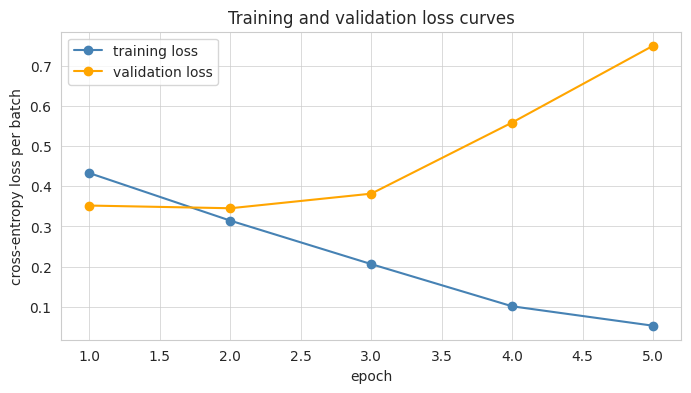

########################################

Metrics for training
accuracy: 0.9963
balanced accuracy: 0.9943
precision: 0.9941
recall: 0.9906

########################################

Metrics for validation
accuracy: 0.8365
balanced accuracy: 0.7474
precision: 0.6992
recall: 0.5741

########################################



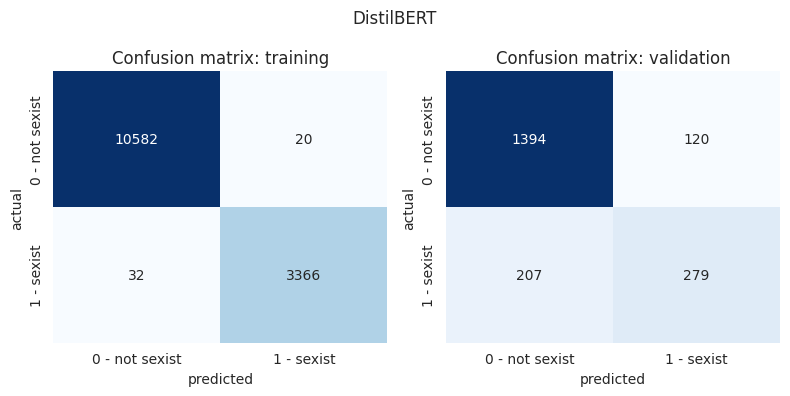

In [9]:
distilbert_model = BERTModel("DistilBERT")
distilbert_model.count_parameters()
distilbert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = distilbert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=distilbert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x

distilbert_model.clear_gpu_memory()

### Results

In [10]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,RoBERTa,training,0.991643,0.991183,0.975645,0.990288
1,RoBERTa,validation,0.849500,0.801400,0.683897,0.707819
2,DeBERTa,training,0.757286,0.500000,0.000000,0.000000
3,DeBERTa,validation,0.757000,0.500000,0.000000,0.000000
4,HateBERT,training,0.996357,0.995395,0.991483,0.993526
5,HateBERT,validation,0.862500,0.786235,0.757946,0.637860
6,DistilBERT,training,0.996286,0.994348,0.994093,0.990583
7,DistilBERT,validation,0.836500,0.747407,0.699248,0.574074


### Different aggregation methods

Let's train `HateBERT` under 6 different scenarios to explore potential performance improvements, using combinations of dataset types (balanced/unbalanced) and label aggregation methods (original labels, majority voting, at least one sexist).

In [11]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])

**1. original labels**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 161.1326
Validation Loss: 19.9990, Validation Accuracy: 0.8680
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 100.7085
Validation Loss: 20.9481, Validation Accuracy: 0.8605
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 43.4866
Validation Loss: 28.3120, Validation Accuracy: 0.8610
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 21.5579
Validation Loss: 41.4724, Validation Accuracy: 0.8610
No improvement. Patience: 3/3
Early stopping triggered.


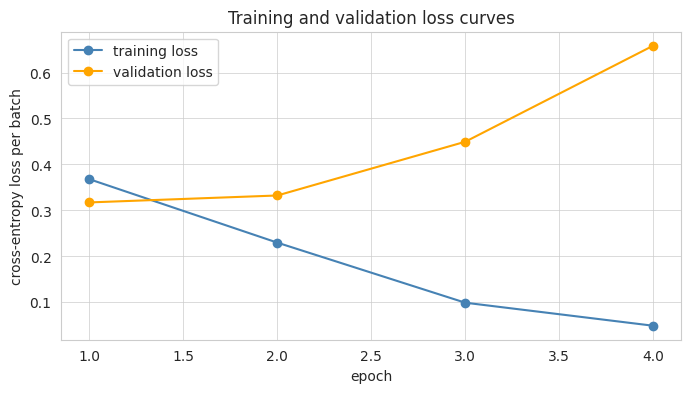

########################################

Metrics for training
accuracy: 0.9990
balanced accuracy: 0.9985
precision: 0.9982
recall: 0.9976

########################################

Metrics for validation
accuracy: 0.8610
balanced accuracy: 0.7769
precision: 0.7680
recall: 0.6132

########################################



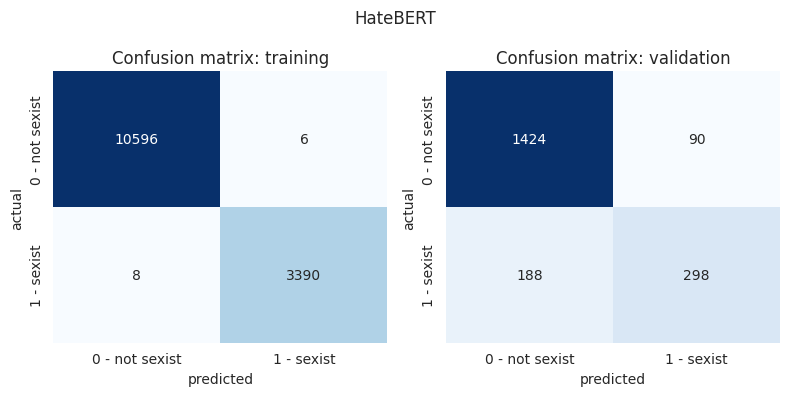

In [12]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_original")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['original']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 130.7553
Validation Loss: 21.3214, Validation Accuracy: 0.8490
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 51.3000
Validation Loss: 30.3896, Validation Accuracy: 0.8385
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 22.1057
Validation Loss: 35.9390, Validation Accuracy: 0.8375
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 12.0286
Validation Loss: 47.8051, Validation Accuracy: 0.8140
No improvement. Patience: 3/3
Early stopping triggered.


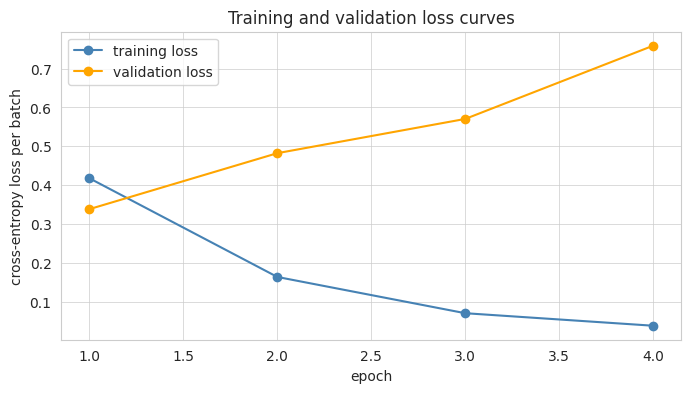

########################################

Metrics for training
accuracy: 0.9942
balanced accuracy: 0.9942
precision: 0.9901
recall: 0.9984

########################################

Metrics for validation
accuracy: 0.8140
balanced accuracy: 0.7989
precision: 0.5899
recall: 0.7695

########################################



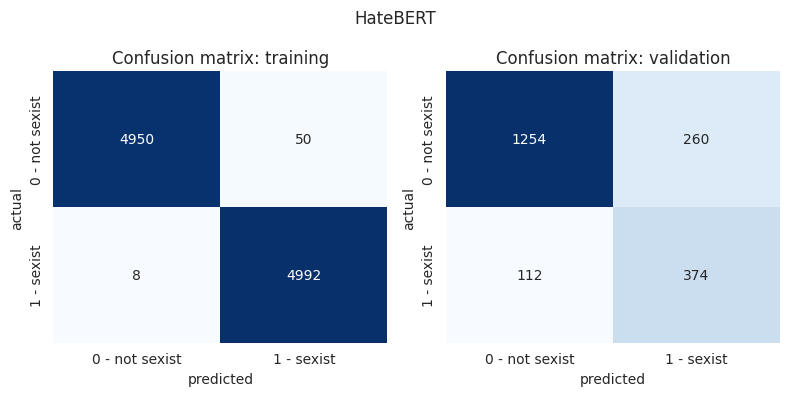

In [13]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_original")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced, X_val, y_val, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced, y_val], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['original']

hatebert_model.clear_gpu_memory()

**2. majority voting**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 169.7361
Validation Loss: 20.9225, Validation Accuracy: 0.8635
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 108.3279
Validation Loss: 22.1269, Validation Accuracy: 0.8620
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 49.5537
Validation Loss: 30.2544, Validation Accuracy: 0.8575
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 26.3620
Validation Loss: 43.1039, Validation Accuracy: 0.8515
No improvement. Patience: 3/3
Early stopping triggered.


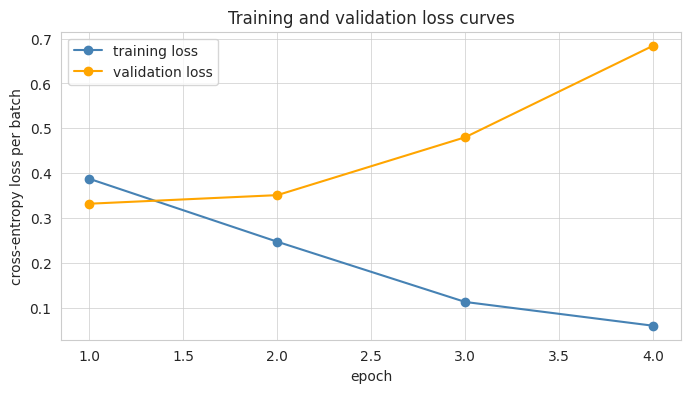

########################################

Metrics for training
accuracy: 0.9975
balanced accuracy: 0.9972
precision: 0.9933
recall: 0.9965

########################################

Metrics for validation
accuracy: 0.8515
balanced accuracy: 0.7751
precision: 0.7167
recall: 0.6284

########################################



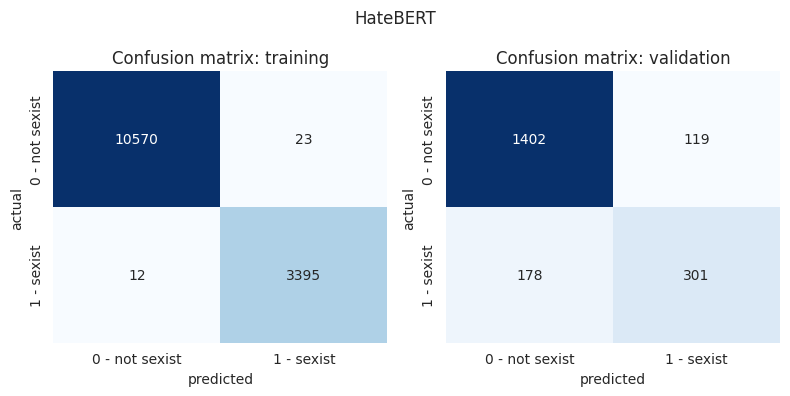

In [14]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_majority_voting")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train_mv, X_val, y_val_mv, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train_mv, y_val_mv], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['majority voting']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 133.9109
Validation Loss: 22.9550, Validation Accuracy: 0.8515
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 53.9178
Validation Loss: 31.8351, Validation Accuracy: 0.8305
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 20.1255
Validation Loss: 34.8198, Validation Accuracy: 0.8415
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 11.8042
Validation Loss: 38.1438, Validation Accuracy: 0.8455
No improvement. Patience: 3/3
Early stopping triggered.


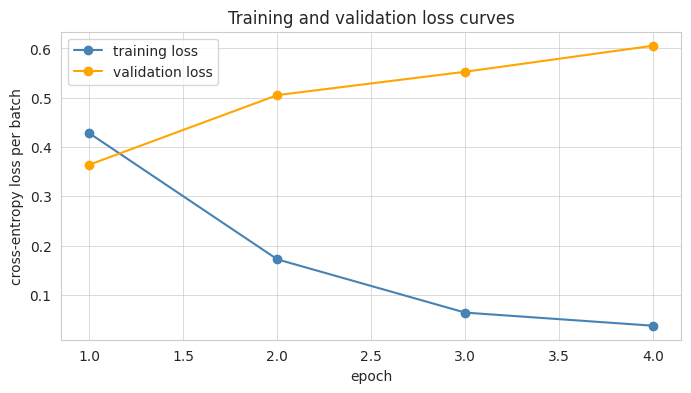

########################################

Metrics for training
accuracy: 0.9974
balanced accuracy: 0.9974
precision: 0.9974
recall: 0.9970

########################################

Metrics for validation
accuracy: 0.8455
balanced accuracy: 0.7697
precision: 0.6986
recall: 0.6242

########################################



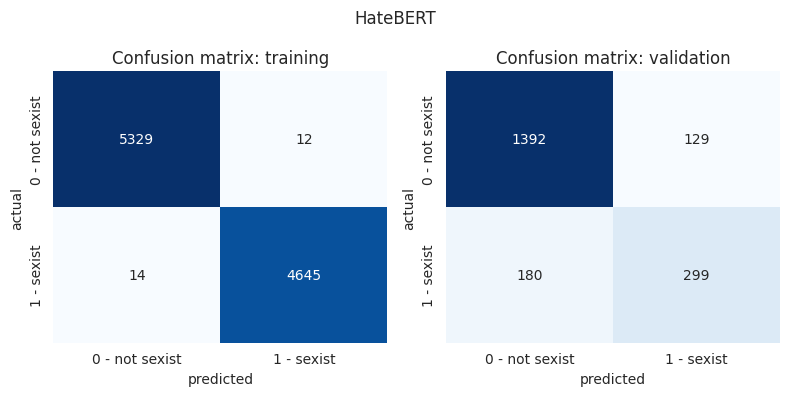

In [15]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_majority_voting")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced_mv, X_val, y_val_mv, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced_mv, y_val_mv], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['majority voting']

hatebert_model.clear_gpu_memory()

**3. at least one sexist**

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 210.8166
Validation Loss: 26.8182, Validation Accuracy: 0.8015
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 143.2198
Validation Loss: 29.0132, Validation Accuracy: 0.7880
No improvement. Patience: 1/3
Epoch 3/10, Cross-entropy Loss: 60.9590
Validation Loss: 37.3665, Validation Accuracy: 0.7860
No improvement. Patience: 2/3
Epoch 4/10, Cross-entropy Loss: 28.8237
Validation Loss: 58.3340, Validation Accuracy: 0.7915
No improvement. Patience: 3/3
Early stopping triggered.


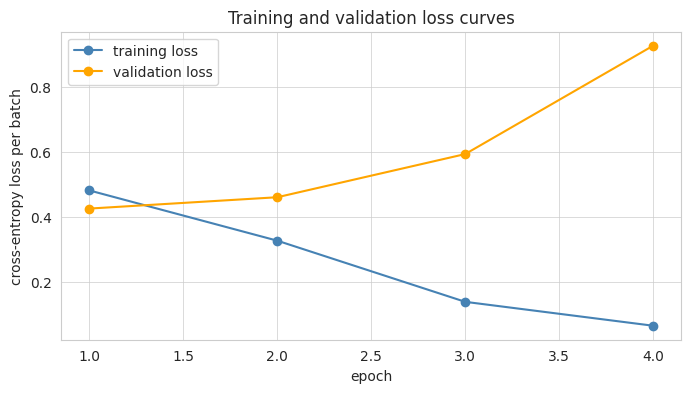

########################################

Metrics for training
accuracy: 0.9963
balanced accuracy: 0.9963
precision: 0.9935
recall: 0.9966

########################################

Metrics for validation
accuracy: 0.7915
balanced accuracy: 0.7719
precision: 0.7058
recall: 0.7048

########################################



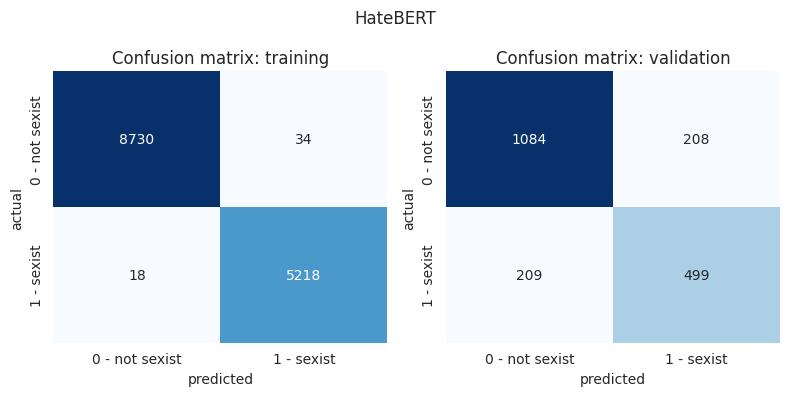

In [16]:
hatebert_model = BERTModel("HateBERT", additional_info="unbalanced_at_least_one_sexist")
hatebert_model.count_parameters()
hatebert_model.train(X_train, y_train_alos, X_val, y_val_alos, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train, "validation": X_val}, [y_train_alos, y_val_alos], model_name=hatebert_model.model_name)
for res_x in res:
    results.loc[len(results)] = res_x + ['at least one sexist']

hatebert_model.clear_gpu_memory()

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading tokenizer...
Tokenizer loaded sucessfully.
Total number of parameters in the model HateBERT: 109483778
Training started.
Epoch 1/10, Cross-entropy Loss: 140.1499
Validation Loss: 36.2498, Validation Accuracy: 0.7305
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 2/10, Cross-entropy Loss: 80.2178
Validation Loss: 34.0322, Validation Accuracy: 0.7880
New best model found! Saving to best_model.
Model saved to best_model.
Epoch 3/10, Cross-entropy Loss: 32.1967
Validation Loss: 39.8891, Validation Accuracy: 0.7935
No improvement. Patience: 1/3
Epoch 4/10, Cross-entropy Loss: 15.1471
Validation Loss: 63.2321, Validation Accuracy: 0.7815
No improvement. Patience: 2/3
Epoch 5/10, Cross-entropy Loss: 11.3313
Validation Loss: 60.7682, Validation Accuracy: 0.7805
No improvement. Patience: 3/3
Early stopping triggered.


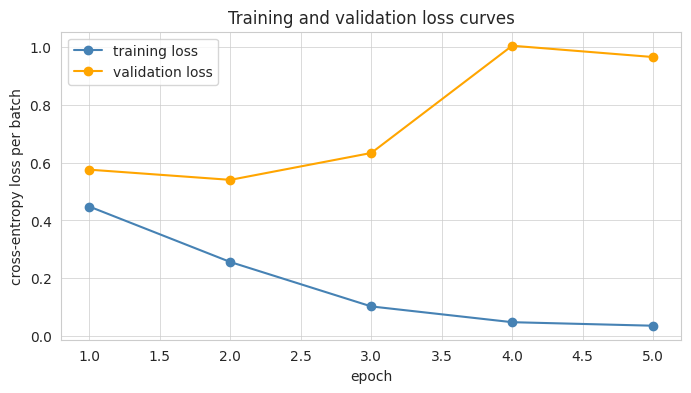

########################################

Metrics for training
accuracy: 0.9980
balanced accuracy: 0.9978
precision: 0.9976
recall: 0.9990

########################################

Metrics for validation
accuracy: 0.7805
balanced accuracy: 0.7765
precision: 0.6658
recall: 0.7627

########################################



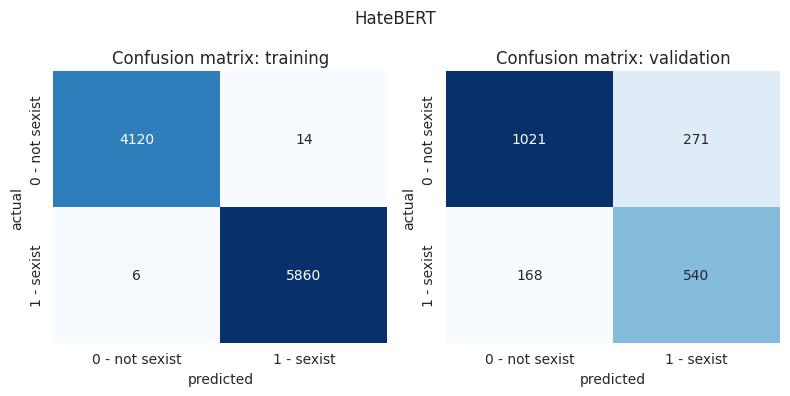

In [17]:
hatebert_model = BERTModel("HateBERT", additional_info="balanced_at_least_one_sexist")
hatebert_model.count_parameters()
hatebert_model.train(X_train_balanced, y_train_balanced_alos, X_val, y_val_alos, epochs=10, patience=3)

res = hatebert_model.evaluate({"training": X_train_balanced, "validation": X_val}, [y_train_balanced_alos, y_val_alos], model_name=hatebert_model.model_name)
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['at least one sexist']

hatebert_model.clear_gpu_memory()

#### Results

In [18]:
results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model    Aggregation Type                                               
HateBERT at least one sexist    training  0.996286           0.996341   
         at least one sexist  validation  0.791500           0.771906   
         majority voting        training  0.997500           0.997153   
         majority voting      validation  0.851500           0.775077   
         original               training  0.999000           0.998540   
         original             validation  0.861000           0.776862   

                              Precision    Recall  
Model    Aggregation Type                          
HateBERT at least one sexist   0.993526  0.996562  
         at least one sexist   0.705799  0.704802  
         majority voting       0.993271  0.996478  
         majority voting       0.716667  0.628392  
         original              0.998233  0.997646  
         original              0.768041  0.613169

In [19]:
balanced_results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model    Aggregation Type                                               
HateBERT at least one sexist    training    0.9980           0.997795   
         at least one sexist  validation    0.7805           0.776480   
         majority voting        training    0.9974           0.997374   
         majority voting      validation    0.8455           0.769702   
         original               training    0.9942           0.994200   
         original             validation    0.8140           0.798908   

                              Precision    Recall  
Model    Aggregation Type                          
HateBERT at least one sexist   0.997617  0.998977  
         at least one sexist   0.665845  0.762712  
         majority voting       0.997423  0.996995  
         majority voting       0.698598  0.624217  
         original              0.990083  0.998400  
         original              0.589905  0.769547

# Qualitative analysis of HateBERT model

In [20]:
bert_model = BERTModel("HateBERT", load_path="best_model", additional_info="balanced_original") # load from checkpoint

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/NLP_24W_VSHJ/challenges/bert_models.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlist

Pretrained weights loaded successfully.
Loading model weights from best_model...
Model loaded from best_model.
Loading tokenizer...
Tokenizer loaded sucessfully.


# HateBERT vs. RNN

- HateBERT predictions on test set

In [ ]:
bert_model = BERTModel("HateBERT", load_path="best_model", additional_info="balanced_at_least_one_sexist") # load from checkpoint
y_test_pred_bert = bert_model.predict(X_test)

Loading pretrained weights: HateBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained weights loaded successfully.
Loading model weights from best_model...


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\challenges\bert_models.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(mod

Model loaded from best_model.
Loading tokenizer...
Tokenizer loaded sucessfully.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


- RNN predictions on test set

In [ ]:
from import_preprocess import convert_labels_to_string, convert_labels_to_int

rnn_model = baseline_models.LSTM_Model()
rnn_model.train(X_train_balanced, convert_labels_to_int(y_train_balanced_alos), X_val, convert_labels_to_int(y_val_alos)) # train LSTM

y_test_pred_rnn = convert_labels_to_string(rnn_model.predict(X_test))

Epoch 1/200
313/313 [==============================] - 7s 20ms/step - loss: 0.6792 - accuracy: 0.5864 - val_loss: 0.7634 - val_accuracy: 0.3540
Epoch 2/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6787 - accuracy: 0.5870 - val_loss: 0.7395 - val_accuracy: 0.3540
Epoch 3/200
313/313 [==============================] - 8s 24ms/step - loss: 0.6786 - accuracy: 0.5870 - val_loss: 0.7657 - val_accuracy: 0.3540
Epoch 4/200
313/313 [==============================] - 9s 28ms/step - loss: 0.6337 - accuracy: 0.6409 - val_loss: 0.6538 - val_accuracy: 0.7005
Epoch 5/200
313/313 [==============================] - 8s 24ms/step - loss: 0.4599 - accuracy: 0.7983 - val_loss: 0.6793 - val_accuracy: 0.6710
Epoch 6/200
313/313 [==============================] - 7s 23ms/step - loss: 0.3469 - accuracy: 0.8586 - val_loss: 0.5552 - val_accuracy: 0.7400
Epoch 7/200
313/313 [==============================] - 7s 23ms/step - loss: 0.2842 - accuracy: 0.8929 - val_loss: 0.6401 - val_accuracy:

In [ ]:
def calculate_confusion_indices(y_true, y_pred):
    """
    Returns: 
    indices = {"TP": list of indices of true positives,
               "FN": list of indices of false negatives,
               "FP": list of indices of false positives,
               "TN": list of indices of true negatives
              }
    """
    indices = {
        "TP": [],  # true positives
        "FN": [],  # false negatives
        "FP": [],  # false positives
        "TN": []   # true negatives
    }
    for idx, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true == "sexist" and pred == "sexist":
            indices["TP"].append(idx)
        elif true == "sexist" and pred == "not sexist":
            indices["FN"].append(idx)
        elif true == "not sexist" and pred == "sexist":
            indices["FP"].append(idx)
        elif true == "not sexist" and pred == "not sexist":
            indices["TN"].append(idx)
    return indices


bert_indices = calculate_confusion_indices(y_test_alos, y_test_pred_bert)
rnn_indices = calculate_confusion_indices(y_test_alos, y_test_pred_rnn)

As shown in the chart below, HateBERT is more effective at detecting real sexism (evidenced by the higher number of true positives) and makes fewer problematic errors (with fewer false negatives, which are the more problematic error type in sexism detection).

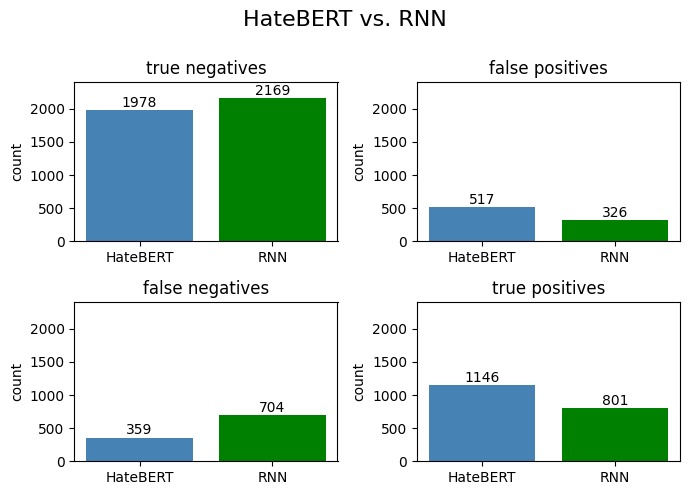

In [59]:
categories = ["TN", "FP", "FN", "TP"]
bert_values = [len(bert_indices[key]) for key in categories]
rnn_values = [len(rnn_indices[key]) for key in categories]

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
fig.suptitle("HateBERT vs. RNN", fontsize=16)
metric_titles = ["true negatives", "false positives", "false negatives", "true positives"]

for i, ax in enumerate(axes.flat):
    # bar chart
    bars = ax.bar(["HateBERT", "RNN"], [bert_values[i], rnn_values[i]], color=["steelblue", "green"])
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 0.5,  
            str(bar.get_height()),  
            ha="center", va="bottom"
        )

    ax.set_title(metric_titles[i])
    ax.set_ylabel("count")
    # ax.set_ylim(0, max(bert_values[i], rnn_values[i]) + 200) 
    ax.set_ylim(0, 2400)

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()


Let's compare results across models... Can we somehow use RNN to improve HateBERT?

In [63]:
comparison = {
    "TN_BERT_not_RNN": list(set(bert_indices["TN"]) - set(rnn_indices["TN"])),
    "TN_RNN_not_BERT": list(set(rnn_indices["TN"]) - set(bert_indices["TN"])),
    "FP_BERT_not_RNN": list(set(bert_indices["FP"]) - set(rnn_indices["FP"])),
    "FP_RNN_not_BERT": list(set(rnn_indices["FP"]) - set(bert_indices["FP"])),
    "FN_BERT_not_RNN": list(set(bert_indices["FN"]) - set(rnn_indices["FN"])),
    "FN_RNN_not_BERT": list(set(rnn_indices["FN"]) - set(bert_indices["FN"])),
    "TP_BERT_not_RNN": list(set(bert_indices["TP"]) - set(rnn_indices["TP"])),
    "TP_RNN_not_BERT": list(set(rnn_indices["TP"]) - set(bert_indices["TP"]))
}

In [ ]:
def retrieve_test_sentences(comparison, S_test, y_test_multi, y_test_alos, key="TN_BERT_not_RNN"):
    """
    Example: 
    If key="TN_BERT_not_RNN" this will retrieve all sentences that are true negative (TN) for HateBERT, 
    but not for RNN (-> HateBERT classified them correctly as "not sexist", RNN incorrectly as "sexist").
    """
    print(key)
    indices = comparison[key]
    print(f"There are: {len(indices)} sentences.")
    for i in indices:
        print(f"{y_test_multi[i]}, alos: {y_test_alos[i]}, {S_test[i]}")

**Based on the plot above, RNN is better in terms of TNs (higher number of TNs).**

Sentences that are TN for RNN, but not for HateBERT (classified correctly as "not sexist" by RNN, but incorectly "sexist" by HateBERT).

**Based on the plot above, RNN is better in terms of FPs (smaller number of FPs).**

Sentences that are FP for HateBERT, but not for RNN (classified correctly as "not sexist" by RNN, but incorectly "sexist" by HateBERT).

These 2 observations are essentially the same.

| actual (alos label) | "not sexist"  |
|-----|--------|
| RNN  | "not sexist" |
| HateBERT   | "sexist" |

1. "Same here lol I used to call my wives father my step dad on accident all the time. Lol"

    Humorous context, but HateBERT might misinterpret "wife's father" combined with "stepdad".
2. "tfw a girl will never even so much as smile because of your presence."

    Sarcastic context, commenting on the lack of response from a girl. "Girl" was not intended to be sexist here, but HateBERT misclassified.
3. "Greedy git isn't he! Has he asked for a payoff yet? To make it go away I mean."

    Criticizing some man for being greedy and asking for a payoff, but it's definitely not sexist. HateBERT might misclassified this because of "git" which is derogatory. 
4. "Just as well! The average Jewish mother would castrate any dirty old men in fancy dress coming down the chimney in the middle of the night to give candy to their prepubecent kids. In Israel, the kids would join in on the beat down."

    Commenting gender and cultural stereotypes, but with really "strong" language ("castrate", "dirty old man"), so HateBERT interprets it as "sexist".

5. "Most men know instinctually the game. But their ego's are so fucking big that they think, Not mine, Not me. Bang bang she shot me down bang bang."

    Derogatory tone ("fucking big ego") associated with "most men", so it's misclassified by HateBERT.

6. "Damn...hot white woman""

    Commenting woman's physical appearance, but including racial and gender terms, which may trigger HateBERT's sensitivity to such language and lead to a misclassification as "sexist".


In [89]:
retrieve_test_sentences(comparison, S_test, y_test_multi, y_test_alos, key="TN_RNN_not_BERT") # hateBERT classified them as "sexist"

TN_RNN_not_BERT
There are: 343 sentences.
['not sexist', 'not sexist', 'not sexist'], alos: not sexist, Same here lol I used to call my wives father my step dad on accident all the time. Lol
['not sexist', 'not sexist', 'not sexist'], alos: not sexist, tfw a girl will never even so much as smile because of your presence.
['not sexist', 'not sexist', 'not sexist'], alos: not sexist, Greedy git isn't he! Has he asked for a payoff yet? To make it go away I mean.
['not sexist', 'not sexist', 'not sexist'], alos: not sexist, Just as well! The average Jewish mother would castrate any dirty old men in fancy dress coming down the chimney in the middle of the night to give candy to their prepubecent kids. In Israel, the kids would join in on the beat down.
['not sexist', 'not sexist', 'not sexist'], alos: not sexist, Most men know instinctually the game. But their ego's are so fucking big that they think, Not mine, Not me. Bang bang she shot me down bang bang.
['not sexist', 'not sexist', 'not 

# Autoregressive models: LLAMA